In [ ]:
!pip install pandas
!pip install numpy
!pip install folium
!conda install osmnx
!conda install networkx
!pip install json
!pip install requests

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import numpy as np
from haversine import haversine
from selenium import webdriver
import folium
import json
import os
import urllib.request
import time
import sys

### 데이터 전처리

In [3]:
# 경로를 나타낼 지역 노드 확인
places = ['중구, 서울, 대한민국', '용산구, 서울, 대한민국', '성동구, 서울, 대한민국']
G = ox.graph_from_place(places, network_type = 'walk')
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(G_proj, rebuild_graph = True, tolerance=15, dead_ends=False)
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)

In [17]:
# csv 파일 호출 후 원하는 column만 추출
df_os_intersec = pd.read_csv('서울_중구_용산구_성동구_os노드.csv', encoding = 'CP949')
df_os_intersec = df_os_intersec[['lat', 'lon']]
df_cctv = pd.read_csv('중구_용산구_성동구 cctv.csv', encoding = 'CP949')
df_cctv = df_cctv[['lat', 'lon']]
df_st_lig = pd.read_csv('중구_용산구_성동구 보안등.csv', encoding = 'CP949')
df_st_lig = df_st_lig[['lat', 'lon']]
df_tr_lig = pd.read_csv('중구_용산구_성동구 횡단보도.csv', encoding = 'CP949')
df_tr_lig = df_tr_lig[['lat', 'lon']]

# 후에 비교 후 찾기 위한 csv 파일
df_os_id = pd.read_csv('서울_중구_용산구_성동구_os노드.csv', encoding = 'CP949')
df_os_id = df_os_id['lat']

# os패키지 위도기준으로 오름차순 정렬
df_os_intersec = df_os_intersec.sort_values(by = ['lat'], ascending = True)
df_os_intersec.head()

,lat,lon
2158,37.514975,126.982874
2159,37.515340,126.983221
4694,37.515573,126.983079
13,37.515965,126.986348
288,37.516241,126.979701


In [5]:
# 불러온 데이터 2차원 리스트로 변형
def make_2d_list(df):
    x1 = []
    x2 = []
    for i in range(len(df)):
        x1.append(df.iloc[i, 0])
        x2.append(df.iloc[i, 1])
    list2 = list(zip(x1, x2))
    return list2

os_node_list = make_2d_list(df_os_intersec)
cctv_node_list = make_2d_list(df_cctv)
st_lig_node_list = make_2d_list(df_st_lig)
tr_lig_node_list = make_2d_list(df_tr_lig)

In [6]:
#오름차순 정렬된 os노드 패키지의 위도 경도 기반 cctv와 보안등, 횡단보도간 직선거리 haversine으로 계산
def make_short_distance_dataframe(lis1, lis2):
    y = []
    for i in range(len(lis1)):
        min_x = 10.0 #or float('inf')
        for j in range(len(lis2)):
            x = haversine(lis1[i], lis2[j], unit = 'km')
            if  x < min_x:
                min_x = x
        y.append(min_x)
    mergedf = pd.DataFrame(data = y, index = os_node_list, columns = ['Min_distance'])
    return mergedf

In [7]:
# osmnx 패키지 노드와 cctv간 직선거리 계산
df_os_to_cctv = make_short_distance_dataframe(os_node_list, cctv_node_list)
df_os_to_cctv['location'] = df_os_to_cctv.index

In [8]:
# osmnx 패키지 노드와 보안등간 직선거리 계산
df_os_to_st_lig = make_short_distance_dataframe(os_node_list, st_lig_node_list)
df_os_to_st_lig['location'] = df_os_to_st_lig.index

In [9]:
# osmnx 패키지 노드와 횡단보도간 직선거리 계산
df_os_to_tr_lig = make_short_distance_dataframe(os_node_list, tr_lig_node_list)
df_os_to_tr_lig['location'] = df_os_to_tr_lig.index

In [10]:
#인덱스를 count 숫자로 변형
df_os_to_cctv.reset_index(drop = True, inplace = True)
df_os_to_st_lig.reset_index(drop = True, inplace = True)
df_os_to_tr_lig.reset_index(drop = True, inplace = True)

# cctv, 보안등과 가까우면 +1점, 신호등과 가까우면 2배 감점
df_os_to_cctv['rank'] = df_os_to_cctv['Min_distance'].rank(method = 'max', ascending = False)
df_os_to_cctv
df_os_to_st_lig['rank'] = df_os_to_st_lig['Min_distance'].rank(method = 'max', ascending = False)
df_os_to_st_lig
df_os_to_tr_lig['rank'] = df_os_to_tr_lig['Min_distance'].rank(method = 'max', ascending = False)
df_os_to_tr_lig
df_node_score = df_os_to_cctv + df_os_to_st_lig + df_os_to_tr_lig
df_node_score['score'] = df_os_to_cctv['rank'] + df_os_to_st_lig['rank'] - 2*df_os_to_tr_lig['rank']
df_node_score = df_node_score['score']
df_node_score.head()

0   -3045.0
1   -5715.0
2   -6191.0
3    -393.0
4    -167.0
Name: score, dtype: float64

### 원형코스 출발지, 거리 설정

In [12]:
start_lo = input("출발지를 입력하세요 : ")
end_lo = input("목적지를 입력하세요(없으면 no를 입력하세요) : ")

if (end_lo == 'no'):
    dist = int(input("운동할 거리가 몇 km 되나요? : "))
    dist = dist*1000

    br = webdriver.Chrome('./chromedriver')
    br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(start_lo))
    s_id = br.find_element_by_css_selector('a.item_address._btnAddress')
    start_juso = s_id.text[5:]

    def search_map(search_text):
        mytext = urllib.parse.quote(search_text)
        url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+mytext
        client_id = 'xheavx7ntb'
        client_secret = 'otYcVEJgDKbT7Hj9VTyDGGD58G7YUQdn258ZPYd5'
        request = urllib.request.Request(url)
        request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
        request.add_header('X-NCP-APIGW-API-KEY', client_secret)
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode == 200):
            response_body = response.read()
            return response_body.decode('utf-8')
        else:
            print("error code : " + rescode)

    s_lo = search_map(start_juso)
    s_lo = json.loads(s_lo)
    s_lo = s_lo['addresses'][0]
    #print(user)
    s_lat = float(s_lo['y'])      #start_latitude
    s_lon = float(s_lo['x'])
    print("출발지 위도는 {} 경도는 {} 입니다.".format(s_lat, s_lon))

    start_list = [s_lat, s_lon]
    print(start_list)

    br.close()

else:
    br = webdriver.Chrome('./chromedriver')
    br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(start_lo))
    s_id = br.find_element_by_css_selector('a.item_address._btnAddress')
    start_juso = s_id.text[5:]

    br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(end_lo))
    e_id = br.find_element_by_css_selector('a.item_address._btnAddress')
    end_juso = e_id.text[5:]   #슬라이싱으로 원하는 도로명 주소만 가져오기

    def search_map(search_text):
        mytext = urllib.parse.quote(search_text)
        url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+mytext
        client_id = 'xheavx7ntb'
        client_secret = 'otYcVEJgDKbT7Hj9VTyDGGD58G7YUQdn258ZPYd5'
        request = urllib.request.Request(url)
        request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
        request.add_header('X-NCP-APIGW-API-KEY', client_secret)
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode == 200):
            response_body = response.read()
            return response_body.decode('utf-8')
        else:
            print("error code : " + rescode)

    s_lo = search_map(start_juso)
    s_lo = json.loads(s_lo)
    s_lo = s_lo['addresses'][0]
    #print(user)
    s_lat = float(s_lo['y'])      #start_latitude
    s_lon = float(s_lo['x'])
    print("출발지 위도는 {} 경도는 {} 입니다.".format(s_lat, s_lon))

    e_lo = search_map(end_juso)
    e_lo = json.loads(e_lo)
    e_lo = e_lo['addresses'][0]
    #print(user)
    e_lat = float(e_lo['y'])      #end_latitude
    e_lon = float(e_lo['x'])
    print("도착지 위도는 {} 경도는 {} 입니다.".format(e_lat, e_lon))

    start_list = [s_lat, s_lon]
    end_list = [e_lat, e_lon]
    print(start_list)
    print(end_list)

    br.close()

출발지를 입력하세요 : 동국대학교
목적지를 입력하세요(없으면 no를 입력하세요) : no
운동할 거리가 몇 km 되나요? : 5
출발지 위도는 37.5582582 경도는 127.0001869 입니다.
[37.5582582, 127.0001869]


In [44]:
# (0, 0)으로 소실돼 ID를 못찾는 경우 방지
os_node_list5 = make_2d_list(df_os_intersec)

In [67]:
#리스트 초기화
os_node_list = make_2d_list(df_os_intersec)
os_node_list1 = os_node_list
index_list = []

# 리스트에 (0, 0)이 남아 있는지 확인
for i in range(len(os_node_list1)):
    if (os_node_list1[i][0]) == 0:
        print(i)

In [47]:
# 도착지가 없을때
if (end_lo == 'no'):
    def find_next_node(list1, list2, list3):     #시작점, index_list, os_node_list
        in_distance_nodes = []
        in_distance_score = []
        node_location = []
        distance = 550.0
        min_distance = sys.float_info.max

        for i in range(len(list3)):
            x = haversine(list1, list3[i], unit = 'm')
            if (x == 0):   #혹시나 출발지와 노드위치가 같다면
                print("출발지와 노드가 같습니다. 출발지를 다시 설정하세요.")
            if x < distance:
                in_distance_nodes.append(list3[i])
                in_distance_score.append(df_node_score[i])
        in_distance_score.sort()
        #print(in_distance_nodes)
        #print(in_distance_score)

        best_node_score = in_distance_score[-1]

        for i in range(len(df_node_score)):
            if df_node_score[i] == best_node_score:
                index1 = i

        #print(index1, df_node_score[index1])
        list2.append(index1)

        node_location.append(list3[index1])
        node_lat = node_location[0][0]
        node_lon = node_location[0][1]
        next_node_location = [node_lat, node_lon]

        os_node_list1[index1] = (0, 0)

        return next_node_location
    
    def find_orig_id(list1, list2, list3):    # 찾을리스트, 비교할 리스트, 인덱스 리스트
        find_id = []
        for i in range(len(list3)):
            for j in range(len(list2)):
                if list1[list3[i]][0] == list2[j]:
                    find_id.append(j)
        return find_id
    
    # 노드가 이동할때마다 출발지와의 거리를 측정
    def make_route_distance(list1, distance1):
        routes10 = []
        lengths10 = []
        total_distance = 0
        for i in range(len(list1)):
            if (total_distance < 0.5 * distance1):
                walk_distance = 0.0
                routes10.append(nx.shortest_path(G2, list(G2)[list1[i]], list(G2)[list1[i+1]], weight = 'length'))
                walk_distance = nx.shortest_path_length(G2, list(G2)[list1[i]], list(G2)[list1[i+1]], weight = 'length')
                total_distance += walk_distance
                lengths10.append(walk_distance)
                #print("한번한번 길이", walk_distance)
            else:
                final = 0.0
                routes10.append(nx.shortest_path(G2, list(G2)[list1[i]], list(G2)[list1[0]], weight = 'length'))
                final = nx.shortest_path_length(G2, list(G2)[list1[i]], list(G2)[list1[0]], weight = 'length')
                total_distance = total_distance + final
                lengths10.append(final)
                #print("마지막 값", final)
                break    

        return routes10, lengths10, total_distance

In [48]:
def make_auto_route():
    # 설정한 거리에 근접할때 까지 노드를 계속 탐색하며 출발지와의 거리를 측정
    my_nodes = [find_next_node(start_list, index_list, os_node_list1)]
    #print(my_nodes)
    for i in range(25):   #적당히 25번 이내에 값을 찾을 수 있음
        my_nodes.append(find_next_node(my_nodes[i], index_list, os_node_list1))
    
    # 찾은 my_nodes기반 osmnx_id를 탐색해 route를 생성
    os_id_list = find_orig_id(os_node_list5, df_os_id, index_list)
    #print(os_id_list)
    routes6, lenght6, total_distance = make_route_distance(os_id_list, dist)
    
    print("내가 지나온 노드들의 위치는 \n", my_nodes, "\n입니다.")
    print("전체거리 이동한 거리는 {:.2f}km입니다,".format(total_distance/1000))
    
    fig3, ax = ox.plot_graph_routes(G2, routes6, node_size = 2, figsize = (20, 20))
    # 출발지와 거리 입력(원형코스) 종료

[[37.558760500000005, 127.0009224]]
[2925, 1570, 4020, 1534, 4100, 2582, 2565, 2569, 4099, 4101, 4098, 2573, 4082, 4132, 4128, 2580, 2567, 2566, 2572, 4095, 2576, 2561, 2578, 4097, 4096, 4105]
내가 지나온 노드들의 위치는 
 [[37.558760500000005, 127.0009224], [37.56174410516804, 127.00475689551934], [37.560965033397295, 127.00829007463668], [37.55907979999999, 127.0098255], [37.5552662, 127.0066751], [37.55139739999999, 127.0045548], [37.5498323, 127.0058824], [37.5508597635833, 127.00475689606586], [37.55489279999999, 127.0072178], [37.55536751421086, 127.007639621004], [37.5549344, 127.008029], [37.55259709999999, 127.0077348], [37.55375189895989, 127.00748935721798], [37.55259310000001, 127.0053749], [37.5513739, 127.0055877], [37.551967450024165, 127.0050679499934], [37.54983828488621, 127.00688247283064], [37.5490662, 127.0057411], [37.5510224, 127.0054029], [37.55445344382864, 127.00554160875224], [37.552242, 127.0067766], [37.55017755000468, 127.00584354998784], [37.551968406309534, 127.0057

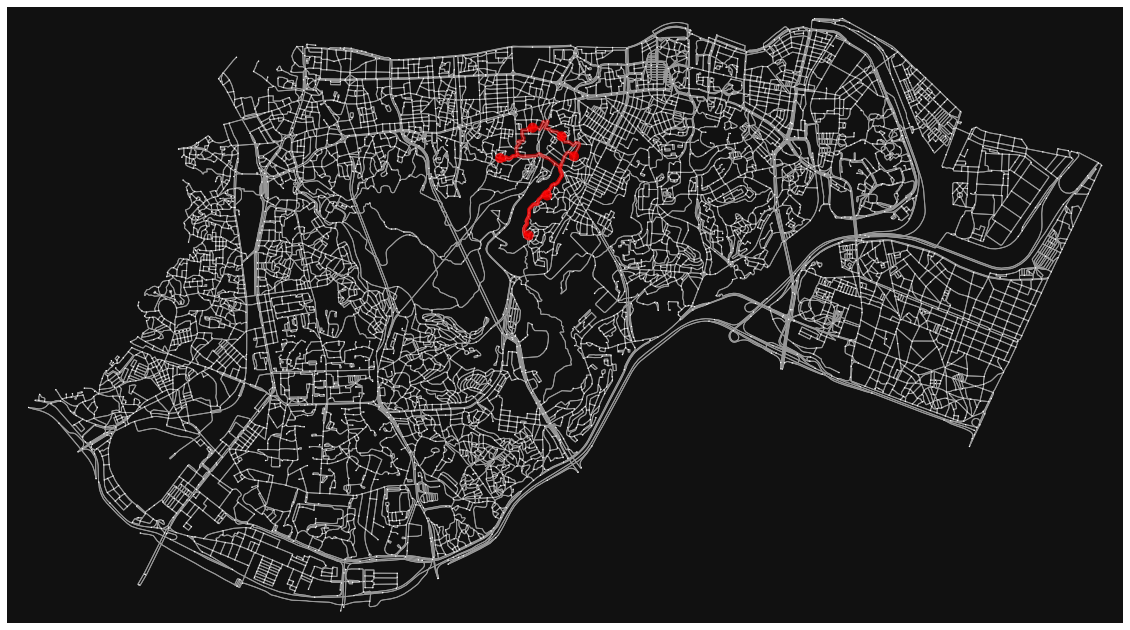

In [49]:
make_auto_route()

### 원형코스 folium 시각화

In [332]:
x = []
y = []
sum_x = 0
sum_y = 0
for i in range(len(my_nodes)):
    x.append(my_nodes[i][0])
    y.append(my_nodes[i][1])
    sum_x += x[i]
    sum_y += y[i]
avg_lat = sum_x/len(x)
avg_lon = sum_y/len(y)

ma = folium.Map(location = start_list, zoom_start = 20)

temp = 0.0

for i in range(len(index_list)):
    temp = float(df_node_score[index_list[i]])
    if (temp < -300.0):
        color1 = 'red'
    elif (temp < 0.0):
        color1 = 'gray'
    elif (temp < 500.0):
        color1 = 'green'
    else:
        color1 = 'blue'
    folium.Marker(location = [x[i], y[i]], popup = df_node_score[index_list[i]],
                 icon = folium.Icon(color = color1)).add_to(ma)

folium.Polygon(locations = my_nodes, tooltip = 'Polygon').add_to(ma)

ma.save('./동국대학교_5km.html')
file_path = os.path.abspath('./동국대학교_5km.html')
br = webdriver.Chrome('./chromedriver')
br.get(file_path)

### 2) 목적지가 있는 경우.

In [52]:
start_lo = input("출발지를 입력하세요 : ")
end_lo = input("목적지를 입력하세요(없으면 no를 입력하세요) : ")

if (end_lo == 'no'):
    dist = int(input("운동할 거리가 몇 km 되나요? : "))
    dist = dist*1000

    br = webdriver.Chrome('./chromedriver')
    br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(start_lo))
    s_id = br.find_element_by_css_selector('a.item_address._btnAddress')
    start_juso = s_id.text[5:]

    def search_map(search_text):
        mytext = urllib.parse.quote(search_text)
        url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+mytext
        client_id = 'xheavx7ntb'
        client_secret = 'otYcVEJgDKbT7Hj9VTyDGGD58G7YUQdn258ZPYd5'
        request = urllib.request.Request(url)
        request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
        request.add_header('X-NCP-APIGW-API-KEY', client_secret)
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode == 200):
            response_body = response.read()
            return response_body.decode('utf-8')
        else:
            print("error code : " + rescode)

    s_lo = search_map(start_juso)
    s_lo = json.loads(s_lo)
    s_lo = s_lo['addresses'][0]
    #print(user)
    s_lat = float(s_lo['y'])      #start_latitude
    s_lon = float(s_lo['x'])
    print("출발지 위도는 {} 경도는 {} 입니다.".format(s_lat, s_lon))

    start_list = [s_lat, s_lon]
    print(start_list)

    br.close()

else:
    br = webdriver.Chrome('./chromedriver')
    br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(start_lo))
    s_id = br.find_element_by_css_selector('a.item_address._btnAddress')
    start_juso = s_id.text[5:]

    br.get('https://m.map.naver.com/search2/search.naver?query={}&sm=hty&style=v5'.format(end_lo))
    e_id = br.find_element_by_css_selector('a.item_address._btnAddress')
    end_juso = e_id.text[5:]   #슬라이싱으로 원하는 도로명 주소만 가져오기

    def search_map(search_text):
        mytext = urllib.parse.quote(search_text)
        url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+mytext
        client_id = 'xheavx7ntb'
        client_secret = 'otYcVEJgDKbT7Hj9VTyDGGD58G7YUQdn258ZPYd5'
        request = urllib.request.Request(url)
        request.add_header('X-NCP-APIGW-API-KEY-ID', client_id)
        request.add_header('X-NCP-APIGW-API-KEY', client_secret)
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode == 200):
            response_body = response.read()
            return response_body.decode('utf-8')
        else:
            print("error code : " + rescode)

    s_lo = search_map(start_juso)
    s_lo = json.loads(s_lo)
    s_lo = s_lo['addresses'][0]
    #print(user)
    s_lat = float(s_lo['y'])      #start_latitude
    s_lon = float(s_lo['x'])
    print("출발지 위도는 {} 경도는 {} 입니다.".format(s_lat, s_lon))

    e_lo = search_map(end_juso)
    e_lo = json.loads(e_lo)
    e_lo = e_lo['addresses'][0]
    #print(user)
    e_lat = float(e_lo['y'])      #end_latitude
    e_lon = float(e_lo['x'])
    print("도착지 위도는 {} 경도는 {} 입니다.".format(e_lat, e_lon))

    start_list = [s_lat, s_lon]
    end_list = [e_lat, e_lon]
    print(start_list)
    print(end_list)

    br.close()

출발지를 입력하세요 : 동국대학교
목적지를 입력하세요(없으면 no를 입력하세요) : 한양대학교
출발지 위도는 37.5582582 경도는 127.0001869 입니다.
도착지 위도는 37.5575753 경도는 127.0466899 입니다.
[37.5582582, 127.0001869]
[37.5575753, 127.0466899]


### 노드별 score의 위도, 경도가 필요하니 데이터 재정의

In [93]:
df_os_to_cctv['rank'] = df_os_to_cctv['Min_distance'].rank(method = 'max', ascending = False)
df_os_to_cctv
df_os_to_st_lig['rank'] = df_os_to_st_lig['Min_distance'].rank(method = 'max', ascending = False)
df_os_to_st_lig
df_os_to_tr_lig['rank'] = df_os_to_tr_lig['Min_distance'].rank(method = 'max', ascending = False)
df_os_to_tr_lig
df_node_score = df_os_to_cctv + df_os_to_st_lig + df_os_to_tr_lig
df_node_score['score'] = df_os_to_cctv['rank'] + df_os_to_st_lig['rank'] - 2*df_os_to_tr_lig['rank']
df_node_score['location'] = os_node_list

df_node_score = df_node_score[['location', 'score']]
x = []
y = []
for i in range(len(df_node_score)):
    x.append(df_node_score.iloc[i][0][0])
    y.append(df_node_score.iloc[i][0][1])
    
df_node_score = df_node_score.drop(['location'], axis = 1)
df_node_score['lat'] = x
df_node_score['lon'] = y
df_node_score

,score,lat,lon
0,-3045.0,37.514975,126.982874
1,-5715.0,37.515340,126.983221
2,-6191.0,37.515573,126.983079
3,-393.0,37.515965,126.986348
4,-167.0,37.516241,126.979701
...,...,...,...
5534,-3793.0,37.572642,127.041464
5535,-8672.0,37.572644,127.038262
5536,-3740.0,37.572736,127.040782
5537,-7290.0,37.572775,127.038457


### 최대한 가까운 노드탐색 함수

In [53]:
def find_similar_node(list1):
    temp = sys.float_info.max
    for i in range(len(os_node_list1)):
        x = haversine(list1, os_node_list1[i], unit = 'm')
        if x < temp:
            temp = x
            find_index = i
    find_node_lat = os_node_list1[find_index][0]
    find_node_lon = os_node_list1[find_index][1]
    find_node = [find_node_lat, find_node_lon]
    return find_node, find_index

### 출발지, 도착지 위치 고려 미로생성

In [83]:
def make_maze():
    # 도착지와 출발지 간 위도 간격
    differ_lat = end_node[0] - start_node[0]
    # 도착지와 출발지 간 걍도 간격
    differ_lon = end_node[1] - start_node[1]
    
    # 출발지와 도착지를 5등분을 위한 변수
    s1 = start_node[0] + 0.2 * differ_lat
    s2 = start_node[0] + 0.4 * differ_lat
    s3 = start_node[0] + 0.6 * differ_lat
    s4 = start_node[0] + 0.8 * differ_lat

    s5 = start_node[1] + 0.2 * differ_lon
    s6 = start_node[1] + 0.4 * differ_lon
    s7 = start_node[1] + 0.6 * differ_lon
    s8 = start_node[1] + 0.8 * differ_lon

    s9 = start_node[0] - 0.8 * differ_lat
    s10 = start_node[0] - 0.6 * differ_lat
    s11 = start_node[0] - 0.4 * differ_lat
    s12 = start_node[0] - 0.2 * differ_lat
    
    
        # 1 사분면 -> 도착지가 출발지보다 위도, 경도가 큰경우
    if ((differ_lat > 0) & (differ_lon > 0)):
        list_max = []
        list_index = []
        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))         #list_max[0][0]
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])
        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        #list_max[1][0]
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

    # 2 사분면 -> 도착지가 출발지보다 위도는 크지만 경도가 작은 경우
    elif ((differ_lat > 0) & (differ_lon < 0)):
        list_max = []
        list_index = []      
        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(start_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < end_node[0]) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

    # 3 사분면 -> 도착지가 출발지보다 위도, 경도 모두 작은경우
    elif ((differ_lat < 0) & (differ_lon < 0)):
        list_max = []
        list_index = []
        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                            & (end_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                            & (s8 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                            & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                            & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                            & (s5 < df_node_score['lon']) & (df_node_score['lon'] < start_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

    # 4 사분면 -> 도착지가 출발지보다 경도는 크지만 위도가 작은경우
    else:
        list_max = []
        list_index = []
        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                    & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                    & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                        & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                        & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(end_node[0] < df_node_score['lat']) & (df_node_score['lat'] < s4) \
                        & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                        & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                        & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                        & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                        & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s4 < df_node_score['lat']) & (df_node_score['lat'] < s3) \
                        & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                        & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                        & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        list_max.append(max(df['score']))
        list_index.append(max(df['score'].index))

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                        & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                        & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s3 < df_node_score['lat']) & (df_node_score['lat'] < s2) \
                        & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                        & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                        & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                        & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                        & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s2 < df_node_score['lat']) & (df_node_score['lat'] < s1) \
                        & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                        & (start_node[1] < df_node_score['lon']) & (df_node_score['lon'] < s5)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                        & (s5 < df_node_score['lon']) & (df_node_score['lon'] < s6)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                        & (s6 < df_node_score['lon']) & (df_node_score['lon'] < s7)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                        & (s7 < df_node_score['lon']) & (df_node_score['lon'] < s8)]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])

        df = df_node_score[(s1 < df_node_score['lat']) & (df_node_score['lat'] < start_node[0]) \
                        & (s8 < df_node_score['lon']) & (df_node_score['lon'] < end_node[1])]
        try:
            list_max.append(max(df['score']))        
            list_index.append(max(df['score'].index))
        except:
            list_max.append(1)
            list_index.append([])
    
    
    # A* 알고리즘을 적용할 미로를 생성
    maze =[]
    list_max1 = []
    list_max2 = []
    list_max3 = []
    list_max4 = []
    list_max5 = []
    list_index1 = []
    list_index2 = []
    list_index3 = []
    list_index4 = []
    list_index5 = []
    for i in range(len(list_max)):
        if i<5:
            list_max1.append(list_max[i])
            list_index1.append(list_index[i])
        elif i<10:
            list_max2.append(list_max[i])
            list_index2.append(list_index[i])
        elif i<15:
            list_max3.append(list_max[i])
            list_index3.append(list_index[i])
        elif i<20:
            list_max4.append(list_max[i])
            list_index4.append(list_index[i])
        else:
            list_max5.append(list_max[i])
            list_index5.append(list_index[i])
    orig_maze = [list_max1, list_max2, list_max3, list_max4, list_max5]
    list_index = [list_index1, list_index2, list_index3, list_index4, list_index5]
    
    
    # 한 행에서 제일 작은값을 1로 변경 -> maze에서 1은 장애물임
    mindex = list_max1.index(min(list_max1))
    list_max1[mindex] = 1
    #print(list_max1)
    mindex = list_max2.index(min(list_max2))
    list_max2[mindex] = 1
    #print(list_max1)
    mindex = list_max3.index(min(list_max3))
    list_max3[mindex] = 1
    #print(list_max3)
    mindex = list_max4.index(min(list_max4))
    list_max4[mindex] = 1
    #print(list_max4)
    mindex = list_max5.index(min(list_max5))
    list_max5[mindex] = 1
    #print(list_max5)
    
    change_maze = [list_max1, list_max2, list_max3, list_max4, list_max5]
    for i in range(len(change_maze)):
        for j in range(len(change_maze)):
            if change_maze[i][j] != 1:
                change_maze[i][j] = 0
    #print(change_maze)
    return change_maze, list_index

### A* 알고리즘 적용

In [74]:
#A* 알고리즘 적용
class Node:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

# Diagonal Distance 기법 이용한 heuristic
def heuristic(node, goal, D=1, D2=2 ** 0.5):  
    dx = abs(node.position[0] - goal.position[0])
    dy = abs(node.position[1] - goal.position[1])
    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)

def aStar(maze, start, end):
    # startNode와 endNode 초기화
    startNode = Node(None, start)
    endNode = Node(None, end)

    # openList, closedList 초기화
    openList = []
    closedList = []

    # openList에 시작 노드 추가
    openList.append(startNode)

    # endNode를 찾을 때까지 실행
    while openList:

        # 현재 노드 지정
        currentNode = openList[0]
        currentIdx = 0

        # 이미 같은 노드가 openList에 있고, f 값이 더 크면
        # currentNode를 openList안에 있는 값으로 교체
        for index, item in enumerate(openList):
            if item.f < currentNode.f:
                currentNode = item
                currentIdx = index

        # openList에서 제거하고 closedList에 추가
        openList.pop(currentIdx)
        closedList.append(currentNode)

        # 현재 노드가 목적지면 current.position 추가하고
        # current의 부모로 이동
        if currentNode == endNode:
            path = []
            current = currentNode
            while current is not None:
                # maze 길을 표시하려면 주석 해제
                # x, y = current.position
                # maze[x][y] = 7 
                path.append(current.position)
                current = current.parent
            return path[::-1]  # reverse

        children = []
        # 인접한 xy좌표 전부
        for newPosition in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]:

            # 노드 위치 업데이트
            nodePosition = (
                currentNode.position[0] + newPosition[0],  # X
                currentNode.position[1] + newPosition[1])  # Y
            
            within_range_criteria = [
                nodePosition[0] > (len(maze) - 1),
                nodePosition[0] < 0,
                nodePosition[1] > (len(maze[len(maze) - 1]) - 1),
                nodePosition[1] < 0,
            ]

            if any(within_range_criteria):  # 하나라도 true면 범위 밖임
                continue

            # 장애물이 있으면 다른 위치 불러오기
            if maze[nodePosition[0]][nodePosition[1]] != 0:
                continue

            new_node = Node(currentNode, nodePosition)
            children.append(new_node)

        # 자식들 모두 loop
        for child in children:

            # 자식이 closedList에 있으면 continue
            if child in closedList:
                continue

            # f, g, h값 업데이트
            child.g = currentNode.g + 1
            child.h = ((child.position[0] - endNode.position[0]) **
                       2) + ((child.position[1] - endNode.position[1]) ** 2)
            # child.h = heuristic(child, endNode) 다른 휴리스틱
            # print("position:", child.position) 거리 추정 값 보기
            # print("from child to goal:", child.h)
            
            child.f = child.g + child.h

            # 자식이 openList에 있으고, g값이 더 크면 continue
            if len([openNode for openNode in openList
                    if child == openNode and child.g > openNode.g]) > 0:
                continue
                    
            openList.append(child)


def astar_main():
    start = (0, 0)
    end = (4, 4)
    path = aStar(my_maze, start, end)
    #print(path)
    
    list_maze_index = []
    for i in range(len(path)):
        list_maze_index.append(path[i])
    
    return list_maze_index

### 원본 osmnx 노드 ID 탐색

In [85]:
def find_orig_node_id(a_route, list1):
    # 알고리즘 결과를 리스트형으로 저장
    maze_index2 = []
    for i in range(len(a_route)):
        maze_index2.append(a_route[i])
    #print(maze_index2)
    # 알고리즘 결과를 기반으로 지나온 node색출
    reverse_index = []
    for i in range(len(maze_index2)):
        reverse_index.append(list1[maze_index2[i][0]][maze_index2[i][1]])
    #print(reverse_index)
    want_index = [start_index] + reverse_index + [end_index]
    # 원하는 index기반으로 dataframe생성
    df_os = pd.DataFrame(os_node_list1)
    df_os = df_os.loc[want_index]
    #print(df_os)
    want_id = []
    for i in range(len(df_os)):
        for j in range(len(df_os_id)):
            if df_os.iloc[i,0] == df_os_id[j]:
                want_id.append(j)

    #print(want_id)
    return want_id

In [91]:
def find_destination(id_list):
    routes = []
    lengths = []
    total_lengths = 0

    for i in range(len(id_list)-1):
        orig_length = 0.0
        routes.append(nx.shortest_path(G2, list(G2)[id_list[i]], list(G2)[id_list[i+1]], weight = 'lenght'))
        orig_length = nx.shortest_path_length(G2, list(G2)[id_list[0]], list(G2)[id_list[i+1]], weight = 'lenght')
        lengths.append(orig_length)

    for i in range(len(lengths)):
        total_lengths += (lengths[i]/10)
    #total_lengths = total_lengths
    print("출발지와 도착지 사이의 거리는 {:.2f}km 입니다.".format(total_lengths))
    fig, ax = ox.plot_graph_routes(G2, routes = routes, node_size = 2, figsize = (15, 15))

[[0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0]]
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
[3634, 3664, 3702, 3734, 3762]
[2601, 4003, 5461, 5524, 3900, 3897, 2051]
출발지와 도착지 사이의 거리는 14.10km 입니다.


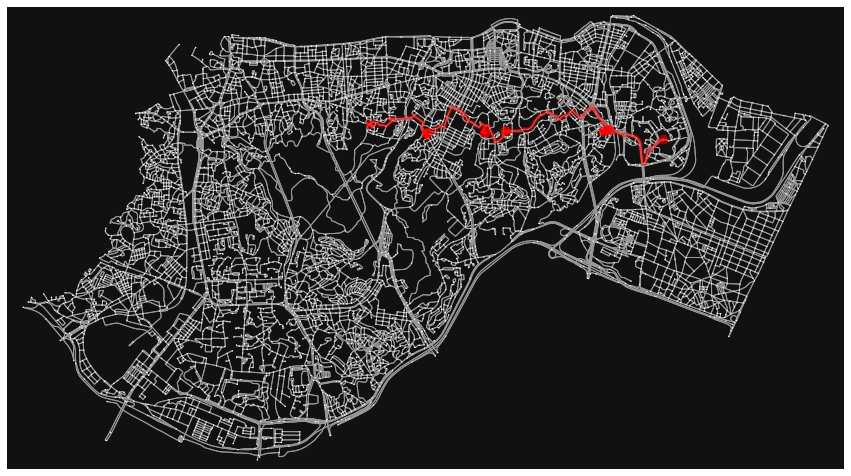

In [94]:
start_node, start_index = find_similar_node(start_list)
end_node, end_index = find_similar_node(end_list)

my_maze, list_index = make_maze()

# a* 알고리즘으로 찾은 최적경로
my_route = astar_main()

my_id = find_orig_node_id(my_route, list_index)

find_destination(my_id)

### 도착지 코스 folium 시각화

In [405]:
# 좀 더 나은 시각화를 위한 folium
x = []
y = []
sum_x = 0
sum_y = 0
for i in range(len(df_os)):
    x.append(df_os.iloc[i][0])
    y.append(df_os.iloc[i][1])
    sum_x += x[i]
    sum_y += y[i]
avg_lat = sum_x/len(x)
avg_lon = sum_y/len(y)

ma = folium.Map(location = start_list, zoom_start = 20)

temp = 0.0

node = list(zip(x, y))

for i in range(len(df_os)):
    temp = float(df_node_score.iloc[index_list[i]][0])
    if (temp < -300.0):
        color1 = 'red'
    elif (temp < 0.0):
        color1 = 'gray'
    elif (temp < 500.0):
        color1 = 'green'
    else:
        color1 = 'blue'
    folium.Marker(location = [x[i], y[i]], popup = df_node_score.iloc[index_list[i]][0],
                 icon = folium.Icon(color = color1)).add_to(ma)

folium.Polygon(locations = node, tooltip = 'Polygon').add_to(ma)

ma.save('./동국대학교-숙명여자대학교.html')
file_path = os.path.abspath('./동국대학교-숙명여자대학교.html')
br = webdriver.Chrome('./chromedriver')
br.get(file_path)